# ehrdata and the physionet2012 challenge dataset

This is a small notebook instructing how

1. To install `ehrdata`
2. Install the required ehrapy package "development install" from the development branch on which ehrapy starts to support time-series operations
3. How `ehrdata` can download and prepare the Physionet2012 Challenge dataset out of the box
4. How a small sequence model can be trained

Resources

- Physionet2012 Challenge Paper: https://ieeexplore.ieee.org/abstract/document/6420376
- Data Link: https://physionet.org/content/challenge-2012/1.0.0/


## 1. Install ehrdata

Install a development version:

In [ ]:
!pip install "ehrdata==0.0.2a1"

## 2. Install ehrapy
The ehrapy package does not yet support time-series operations, as this is a feature we're developing.

But the latest developments can be used by executing the line below. This fetches the ehrapy repository, switches to the time-series branch, and installs the ehrapy package from this branch.

In [ ]:
!git clone https://github.com/theislab/ehrapy.git
!cd ehrapy && git fetch && git checkout feature/time-series && pip install -e .

**IMPORTANT** You need to restart your Jupyter kernel after running the ehrapy dev install; Only then will juptyer recognize the freshly installed ehrapy package.

Once you restarted, you don't need to run the two "installations" above, but can continue directly below here.

## 3. Prepare the Physionet2012 Challenge Dataset

### 3.1 Imports

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
pip install "numpy==1.26.4"

In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
import numpy as np
from pathlib import Path
import ehrdata as ed

### 3.2 Data Loading
The physionet2012 challenge dataset is one of the ready-to-use datasets of `ehrdata`. See the documentation for further information.

In [3]:
edata = ed.dt.physionet2012()

/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/ehrdata/core/ehrdata.py:117: ImplicitModificationWarning: Setting element `.layers['r_layer']` of view, initializing view as actual.
  self.layers[R_LAYER_KEY] = input


The `edata` object contains the data in different fields. The most important ones are

- `edata.r` is 3D n_obs x n_var x n_timesteps numpy array containing the time series data
- `edata.obs` is a dataframe containing static information about the individuals
- `edata.var` is a dataframe which can contain information on the features; here, its quite boring and just the names
- `edata.t` is a dataframe which can contain information about the timeaxis; here, its quite boring and just the number of the hours


In [4]:
edata

EHRData object with n_obs x n_var = 11988 x 37, and a timeseries of 48 steps.
             shape of .X: (0, 0) 
             shape of .r: (11988, 37, 48) 

In [5]:
edata.r.shape

(11988, 37, 48)

In [6]:
edata.r.copy()

array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [ -1.  ,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,   7.4 ,    nan, ...,    nan,    nan,    nan],
        [ 76.  ,    nan,    nan, ...,  81.6 ,  81.6 ,  81.6 ],
        [  7.45,   7.44,    nan, ...,   7.37,    nan,    nan]],

       [[   nan, 127.  ,    nan, ...,    nan,    nan,    nan],
        [   nan,  91.  ,    nan, ...,    nan,    nan,    nan],
        [   nan, 235.  ,    nan, ...,    nan,    nan,    nan],
        ...,
        [   

In [7]:
edata.obs['In-hospital_death'].value_counts()

In-hospital_death
0    10281
1     1707
Name: count, dtype: int64

In [8]:
edata.var

,Parameter
Parameter,
ALP,ALP
ALT,ALT
AST,AST
Albumin,Albumin
BUN,BUN
Bilirubin,Bilirubin
Cholesterol,Cholesterol
Creatinine,Creatinine
DiasABP,DiasABP


In [9]:
# one drop and make it 36 features
edata = edata[:, edata.var_names != "MechVent"] 

/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/ehrdata/core/ehrdata.py:117: ImplicitModificationWarning: Setting element `.layers['r_layer']` of view, initializing view as actual.
  self.layers[R_LAYER_KEY] = input


In [10]:
edata.var.shape,edata.t.shape

((36, 1), (48, 1))

### 4. Training a Sequence Model

#### 4.1 Data Preprocessing

This shows how the data can be split, prepared into a pytorch dataloader, and be used for a small pytorch model. The model itself is not competitive or "good", but is just a small example.

We split the data into train, validation, and test splits, using the "set" labels provided in the Physionet2012 challenge dataset. Any other split is also possible.

In [11]:
from sklearn.model_selection import train_test_split
"""# Step 1: Shuffle and split patient indices
all_indices = np.arange(edata.n_obs)

# Split into 50% train and 50% temp (val + test)
train_idx, temp_idx = train_test_split(all_indices, test_size=0.5, random_state=42)

# Split temp into 30% val and 20% test → test_size=0.4 of temp = 0.2 overall
val_idx, test_idx = train_test_split(temp_idx, test_size=0.4, random_state=42)

# Step 2: Update the `set` column in edata.obs to match the new splits
edata.obs["set"] = None
edata.obs.iloc[train_idx, edata.obs.columns.get_loc("set")] = "set-a"
edata.obs.iloc[val_idx, edata.obs.columns.get_loc("set")] = "set-b"
edata.obs.iloc[test_idx, edata.obs.columns.get_loc("set")] = "set-c"""

# Step 3: Use same logic as before to extract the splits
edata_train = edata[edata.obs["set"] == "set-a"]
edata_val   = edata[edata.obs["set"] == "set-b"]
edata_test  = edata[edata.obs["set"] == "set-c"]

/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/ehrdata/core/ehrdata.py:117: ImplicitModificationWarning: Setting element `.layers['r_layer']` of view, initializing view as actual.
  self.layers[R_LAYER_KEY] = input
/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/ehrdata/core/ehrdata.py:117: ImplicitModificationWarning: Setting element `.layers['r_layer']` of view, initializing view as actual.
  self.layers[R_LAYER_KEY] = input
/opt/anaconda3/envs/goodmimic/lib/python3.12/site-packages/ehrdata/core/ehrdata.py:117: ImplicitModificationWarning: Setting element `.layers['r_layer']` of view, initializing view as actual.
  self.layers[R_LAYER_KEY] = input



We perform a zero-mean and unit-variance normalization. For this, ehrapy provides some functionality:

In [12]:
import ehrapy as ep

In [13]:
scaler3d = ep.ts.StandardScaler3D()

scaler3d.fit_transform(edata_train)
scaler3d.transform(edata_val)
scaler3d.transform(edata_test)

To impute missing values, we now perform last observation carried forward imputation.
There exist also more sophisticated methods for time-series imputation, e.g. [SAITS (Du et al., 2023)](https://doi.org/10.1016/j.eswa.2023.119619).

In [14]:
locf = ep.ts.LOCFImputer()

locf.fit_transform(edata_train)
locf.transform(edata_val)
locf.transform(edata_test)

Finally, let us briefly explore the shape of the data: We have 37 numeric features, measured for 48 hours, and roughly 4'000 patients per split. The dataset is imbalanced, with ca 14% in-hospital death cases per split.

In [15]:
edata

EHRData object with n_obs x n_var = 11988 x 36, and a timeseries of 48 steps.
             shape of .X: (0, 0) 
             shape of .r: (11988, 36, 48) 

In [16]:
edata_val

EHRData object with n_obs x n_var = 3993 x 36, and a timeseries of 48 steps.
             shape of .X: (0, 0) 
             shape of .r: (3993, 36, 48) 

In [17]:
edata_test

EHRData object with n_obs x n_var = 3998 x 36, and a timeseries of 48 steps.
             shape of .X: (0, 0) 
             shape of .r: (3998, 36, 48) 

In [18]:
edata_train

EHRData object with n_obs x n_var = 3997 x 36, and a timeseries of 48 steps.
             shape of .X: (0, 0) 
             shape of .r: (3997, 36, 48) 

In [19]:
print(
    f"positive rate in edata_train: {edata_train.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_train.obs['In-hospital_death'].sum()}"
)

print(
    f"positive rate in edata_val: {edata_val.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_val.obs['In-hospital_death'].sum()}"
)

print(
    f"positive rate in edata_test: {edata_test.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_test.obs['In-hospital_death'].sum()}"
)

positive rate in edata_train: 0.1386, absolute count: 554
positive rate in edata_val: 0.1422, absolute count: 568
positive rate in edata_test: 0.1463, absolute count: 585


#### 4.2 Model preparation

The below part is not very specific for `ehrdata` or `ehrapyz` anymore, but more about `torch`.

It just is a tiny showcase for a sequence model.

We build a small sequence model in pytorch. More elaborate model architectures have been proposed for this dataset. Here, for demonstration purposes and as to avoid complexity, we focus on a simple architecture.

In a nutshell, the model has a GRU block as sequence model, and a classification head.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, f1_score, auc, confusion_matrix


In [21]:
flat_order = list(edata.var.index)

In [22]:
flat_order

['ALP',
 'ALT',
 'AST',
 'Albumin',
 'BUN',
 'Bilirubin',
 'Cholesterol',
 'Creatinine',
 'DiasABP',
 'FiO2',
 'GCS',
 'Glucose',
 'HCO3',
 'HCT',
 'HR',
 'K',
 'Lactate',
 'MAP',
 'Mg',
 'NIDiasABP',
 'NIMAP',
 'NISysABP',
 'Na',
 'PaCO2',
 'PaO2',
 'Platelets',
 'RespRate',
 'SaO2',
 'SysABP',
 'Temp',
 'TroponinI',
 'TroponinT',
 'Urine',
 'WBC',
 'Weight',
 'pH']

In [23]:
# Get feature indices from edata.var
indices = [edata.var.index.get_loc(f) for f in flat_order]

# Reorder time series data in edata.r
edata_train.r = edata_train.r[:, indices, :]
edata_val.r = edata_val.r[:, indices, :]
edata_test.r = edata_test.r[:, indices, :]

In [24]:
edata_train.r.shape

In [25]:
def reshape_to_6x6_tensor(x):
    # x shape: (n_samples, 36, 48)
    x = x.transpose(0, 2, 1)  # → (n_samples, 48, 36)
    x = x.reshape(x.shape[0], x.shape[1], 6, 6)  # → (n_samples, 48, 6, 6)
    x = x[:, :, None, :, :]  # → (n_samples, 48, 1, 6, 6)
    return x


In [26]:
y_train = edata_train.obs["In-hospital_death"].values
y_val = edata_val.obs["In-hospital_death"].values
y_test = edata_test.obs["In-hospital_death"].values

In [51]:
x_train = reshape_to_6x6_tensor(edata_train.r)
x_val = reshape_to_6x6_tensor(edata_val.r)
x_test = reshape_to_6x6_tensor(edata_test.r)

In [52]:
x_train = np.transpose(x_train, (0, 2, 1, 3, 4))
x_val = np.transpose(x_val, (0, 2, 1, 3, 4))
x_test = np.transpose(x_test, (0, 2, 1, 3, 4))

In [53]:
x_train.shape

In [33]:
"""from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np

# Convert y_train to numpy if needed
labels = y_train if isinstance(y_train, np.ndarray) else y_train.numpy()
class_sample_count = np.bincount(labels)
class_weights = 1. / class_sample_count
sample_weights = class_weights[labels]
sample_weights = torch.from_numpy(sample_weights).float()

# Create weighted sampler
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)"""

'from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler\nimport numpy as np\n\n# Convert y_train to numpy if needed\nlabels = y_train if isinstance(y_train, np.ndarray) else y_train.numpy()\nclass_sample_count = np.bincount(labels)\nclass_weights = 1. / class_sample_count\nsample_weights = class_weights[labels]\nsample_weights = torch.from_numpy(sample_weights).float()\n\n# Create weighted sampler\nsampler = WeightedRandomSampler(weights=sample_weights,\n                                num_samples=len(sample_weights),\n                                replacement=True)'

In [54]:
# 2. Convert to tensors
trn_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())
tst_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())

In [55]:
x_train.shape


In [56]:
# 3. Create data loaders
trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)
tst_dl = DataLoader(tst_ds, batch_size=256, shuffle=False)

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [93]:
class CostumConv3d(nn.Module):
    def __init__(self, ni, no, kernel, stride, pad, drop=None, activ=lambda: nn.ReLU(inplace=True)):
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [nn.Conv3d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout3d(drop))  # 3D Dropout for consistency
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class Flatten(nn.Module):
    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

        
# === NEW: Learnable permutation layer ===
class Permutation3DLayer(nn.Module):
    def __init__(self, num_features=36):
        super().__init__()
        self.num_features = num_features
        self.permutation_logits = nn.Parameter(torch.randn(num_features, num_features))  # learnable matrix

    def forward(self, x):
        # Compute soft permutation matrix (row-wise softmax)
        perm = torch.softmax(self.permutation_logits, dim=1)  # shape: (36, 36)

        # Save for inspection
        self.permutation_matrix = perm.detach().cpu().numpy()

        # Reshape input: (B, C=1, T, H=6, W=6) → (B, T, 36)
        B, C, T, H, W = x.shape
        x_flat = x.view(B, T, H * W)  # (B, T, 36)

        # Apply permutation to each time step
        x_permuted = torch.matmul(x_flat, perm.T)  # (B, T, 36)

        # Reshape back to 3D image format
        x_permuted = x_permuted.view(B, C, T, H, W)
        return x_permuted



class Classifier(nn.Module):
    def __init__(self, raw_ni=None, no=2, drop=0.5):
        super().__init__()

        self.permute = Permutation3DLayer(num_features=36)

        self.conv_block = nn.Sequential(
            CostumConv3d(1, 16, kernel=(48, 5, 5), stride=1, pad=1, drop=drop),
            CostumConv3d(16, 32, kernel=(5, 5, 5), stride=1, pad=1, drop=drop),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # → (batch, 32, 1, 1, 1)
        )

        self.flatten = Flatten()

        self.fc = nn.Sequential(
            #nn.Dropout(drop),
            #nn.Linear(32, 64),  
            #nn.ReLU(inplace=True),
            #nn.Dropout(drop),
            #nn.Linear(64, 64),
            #nn.ReLU(inplace=True),
            nn.Linear(32, no)
        )

    def forward(self, t_raw):
        # t_raw shape: (batch, 1, 48, 6, 6)
        x = self.permute(t_raw)
        x = self.conv_block(x)  # → (batch, 32, 1, 1, 1)
        x = self.flatten(x)         # → (batch, 32)
        return self.fc(x)


        
"""class Classifier(nn.Module):
    def __init__(self, raw_ni, no, input_time_steps=48, drop=0.5):
        super().__init__()

        # First and second conv layer
        self.conv_block = nn.Sequential(
            CostumConv1d(raw_ni, 64, kernel=3, stride=1, pad=0, drop=drop),
            CostumConv1d(64, 128, kernel=3, stride=1, pad=0, drop=drop),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.flatten = Flatten()

        # Dynamically calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, raw_ni, input_time_steps)
            dummy_output = self.conv_block(dummy_input)
            flat_dim = dummy_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Dropout(drop), nn.Linear(flat_dim, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True),
            nn.Linear(64, no)
        )

    def forward(self, t_raw):
        x = self.conv_block(t_raw)
        x = self.flatten(x)
        return self.fc(x)"""


'class Classifier(nn.Module):\n    def __init__(self, raw_ni, no, input_time_steps=48, drop=0.5):\n        super().__init__()\n\n        # First and second conv layer\n        self.conv_block = nn.Sequential(\n            CostumConv1d(raw_ni, 64, kernel=3, stride=1, pad=0, drop=drop),\n            CostumConv1d(64, 128, kernel=3, stride=1, pad=0, drop=drop),\n            nn.MaxPool1d(kernel_size=2, stride=2)\n        )\n        self.flatten = Flatten()\n\n        # Dynamically calculate flattened size\n        with torch.no_grad():\n            dummy_input = torch.zeros(1, raw_ni, input_time_steps)\n            dummy_output = self.conv_block(dummy_input)\n            flat_dim = dummy_output.view(1, -1).shape[1]\n\n        self.fc = nn.Sequential(\n            nn.Dropout(drop), nn.Linear(flat_dim, 64), nn.ReLU(inplace=True),\n            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True),\n            nn.Linear(64, no)\n        )\n\n    def forward(self, t_raw):\n        x = self

In [94]:
for epoch in range(1):
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
x_raw.shape,y_batch.shape


(torch.Size([157, 1, 48, 6, 6]), torch.Size([157]))

In [95]:
#raw_feat = x_train.shape[1]  # 37 features = 37 input channels
num_classes = 2
drop = 0.3
loss_history = []
acc_history = []
patience, trials = 200, 0
base, step = 1, 2
best_acc = 0
n_epochs = 100

model = Classifier(no=num_classes, drop=drop).to(device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss() #Compares predicted logits (before softmax) to true labels
opt = optim.Adam(model.parameters(), lr=0.001)

# Example pass-through for shape check
x_dummy = torch.randn(1,1,48,6,6).to(device)
print("Dummy input shape:", x_dummy.shape)
with torch.no_grad():
    print("Output shape:", model(x_dummy).shape)

model = Classifier(no=num_classes, drop=drop).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

print('Start model training')



Dummy input shape: torch.Size([1, 1, 48, 6, 6])
Output shape: torch.Size([1, 2])
Start model training


In [96]:
for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    for x_raw, y_batch in trn_dl:
        x_raw, y_batch = x_raw.to(device), y_batch.to(device)
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()

    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    for x_raw, y_batch in val_dl:
        x_raw, y_batch = x_raw.to(device), y_batch.to(device)
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f"Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}")
        base *= step

    if acc > best_acc:
        best_acc = acc
        trials = 0
        torch.save(model.state_dict(), "best.pth")
        print(f"Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}")
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping on epoch {epoch}")
            break

print("Done!")

Epoch:   1. Loss: 0.5779. Acc.: 85.78%
Epoch 1 best model saved with accuracy: 85.78%
Epoch:   2. Loss: 0.4888. Acc.: 85.78%
Epoch:   4. Loss: 0.4169. Acc.: 85.78%
Epoch 6 best model saved with accuracy: 85.85%
Epoch 7 best model saved with accuracy: 86.15%
Epoch:   8. Loss: 0.3703. Acc.: 86.28%
Epoch 8 best model saved with accuracy: 86.28%
Epoch 10 best model saved with accuracy: 86.33%
Epoch 12 best model saved with accuracy: 86.35%
Epoch 13 best model saved with accuracy: 86.53%
Epoch:  16. Loss: 0.3100. Acc.: 86.80%
Epoch 16 best model saved with accuracy: 86.80%
Epoch 20 best model saved with accuracy: 86.98%
Epoch 22 best model saved with accuracy: 87.03%
Epoch 24 best model saved with accuracy: 87.05%
Epoch:  32. Loss: 0.2619. Acc.: 86.70%
Epoch:  64. Loss: 0.1912. Acc.: 84.90%
Done!


In [97]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

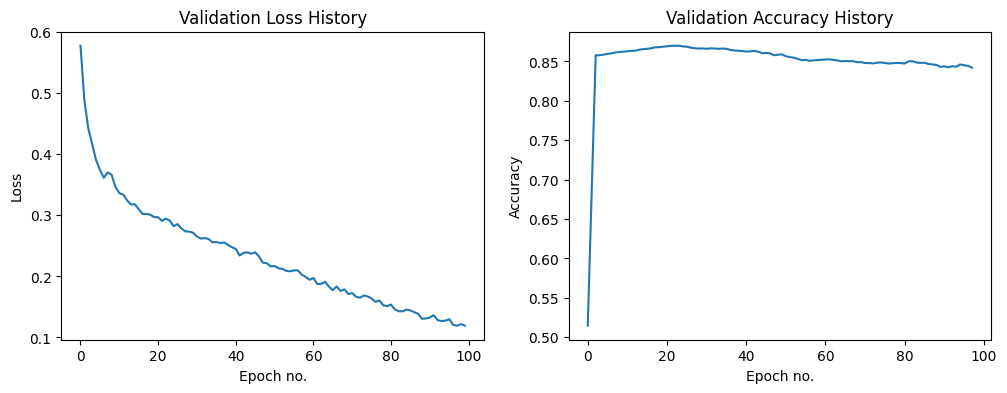

In [98]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [99]:
preds_array = np.array([])
for batch in tst_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1).numpy()
        preds_array = np.concatenate((preds_array, preds), axis=None)

In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds_array)

array([[3130,  283],
       [ 352,  233]])

In [101]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, preds_array, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.90      0.92      0.91      3413
     class 2       0.45      0.40      0.42       585

    accuracy                           0.84      3998
   macro avg       0.68      0.66      0.67      3998
weighted avg       0.83      0.84      0.84      3998



In [102]:
summary(model, input_size=(1,1,48,6,6)) 

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 2]                    --
├─Permutation3DLayer: 1-1                [1, 1, 48, 6, 6]          1,296
├─Sequential: 1-2                        [1, 32, 1, 1, 1]          --
│    └─CostumConv3d: 2-1                 [1, 16, 3, 4, 4]          --
│    │    └─Sequential: 3-1              [1, 16, 3, 4, 4]          19,216
│    └─CostumConv3d: 2-2                 [1, 32, 1, 2, 2]          --
│    │    └─Sequential: 3-2              [1, 32, 1, 2, 2]          64,032
│    └─AdaptiveAvgPool3d: 2-3            [1, 32, 1, 1, 1]          --
├─Flatten: 1-3                           [1, 32]                   --
├─Sequential: 1-4                        [1, 2]                    --
│    └─Linear: 2-4                       [1, 2]                    66
Total params: 84,610
Trainable params: 84,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.18
Input size (MB): 0.01
Forward/back

In [86]:
perm_matrix = model.permute.permutation_matrix


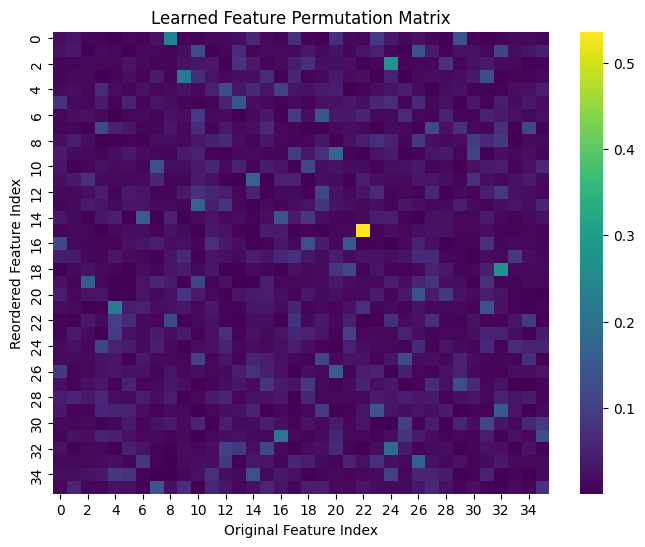

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(perm_matrix, cmap="viridis")
plt.title("Learned Feature Permutation Matrix")
plt.xlabel("Original Feature Index")
plt.ylabel("Reordered Feature Index")
plt.show()


In [88]:
print(model.permute.permutation_matrix)

[[0.01733938 0.02902483 0.00804246 ... 0.01368032 0.01170797 0.00673565]
 [0.02474411 0.03543083 0.00428635 ... 0.01864605 0.02830404 0.0459756 ]
 [0.00942398 0.00527485 0.01173626 ... 0.01377615 0.00318359 0.00635651]
 ...
 [0.01494855 0.01334845 0.01055408 ... 0.01459417 0.0115473  0.01475358]
 [0.01800568 0.02106868 0.02376336 ... 0.00662325 0.00168706 0.01336315]
 [0.01009202 0.05490435 0.00932856 ... 0.01507223 0.00480522 0.07759682]]


In [89]:
import numpy as np

# Let's assume you have your feature names
feature_names = list(edata.var.index)

# For each reordered feature index (row), find the most contributing original feature(s)
for i, row in enumerate(perm_matrix):
    top_feature_idx = np.argmax(row)  # Index of most important original feature
    top_feature = feature_names[top_feature_idx]
    top_weight = row[top_feature_idx]
    print(f"Reordered index {i:2d} ← {top_feature:15s} (weight: {top_weight:.3f})")


Reordered index  0 ← DiasABP         (weight: 0.233)
Reordered index  1 ← RespRate        (weight: 0.132)
Reordered index  2 ← PaO2            (weight: 0.275)
Reordered index  3 ← FiO2            (weight: 0.219)
Reordered index  4 ← HCO3            (weight: 0.124)
Reordered index  5 ← HCT             (weight: 0.138)
Reordered index  6 ← NIDiasABP       (weight: 0.145)
Reordered index  7 ← Albumin         (weight: 0.121)
Reordered index  8 ← TroponinI       (weight: 0.090)
Reordered index  9 ← NIMAP           (weight: 0.176)
Reordered index 10 ← Creatinine      (weight: 0.129)
Reordered index 11 ← HR              (weight: 0.166)
Reordered index 12 ← NIDiasABP       (weight: 0.110)
Reordered index 13 ← GCS             (weight: 0.167)
Reordered index 14 ← Cholesterol     (weight: 0.156)
Reordered index 15 ← Na              (weight: 0.536)
Reordered index 16 ← NISysABP        (weight: 0.147)
Reordered index 17 ← WBC             (weight: 0.086)
Reordered index 18 ← Urine           (weight: 

In [90]:
# Sum of each column across all rows → importance of original feature
feature_importance = perm_matrix.sum(axis=0)

# Sort and display
sorted_idx = np.argsort(feature_importance)[::-1]
print("\nGlobal feature importance (across all reordered positions):")
for idx in sorted_idx[:10]:
    print(f"{feature_names[idx]:15s}: {feature_importance[idx]:.3f}")



Global feature importance (across all reordered positions):
PaO2           : 1.340
Urine          : 1.326
RespRate       : 1.299
Na             : 1.281
GCS            : 1.274
TroponinT      : 1.254
HCO3           : 1.171
NIDiasABP      : 1.162
NIMAP          : 1.156
HR             : 1.135


In [91]:
original_features = list(edata.var.index)
original_features

['ALP',
 'ALT',
 'AST',
 'Albumin',
 'BUN',
 'Bilirubin',
 'Cholesterol',
 'Creatinine',
 'DiasABP',
 'FiO2',
 'GCS',
 'Glucose',
 'HCO3',
 'HCT',
 'HR',
 'K',
 'Lactate',
 'MAP',
 'Mg',
 'NIDiasABP',
 'NIMAP',
 'NISysABP',
 'Na',
 'PaCO2',
 'PaO2',
 'Platelets',
 'RespRate',
 'SaO2',
 'SysABP',
 'Temp',
 'TroponinI',
 'TroponinT',
 'Urine',
 'WBC',
 'Weight',
 'pH']

In [92]:
best_order = perm_matrix.argmax(axis=1)
reordered_features = [original_features[i] for i in best_order]
reordered_features

['DiasABP',
 'RespRate',
 'PaO2',
 'FiO2',
 'HCO3',
 'HCT',
 'NIDiasABP',
 'Albumin',
 'TroponinI',
 'NIMAP',
 'Creatinine',
 'HR',
 'NIDiasABP',
 'GCS',
 'Cholesterol',
 'Na',
 'NISysABP',
 'WBC',
 'Urine',
 'AST',
 'RespRate',
 'BUN',
 'DiasABP',
 'NISysABP',
 'Albumin',
 'Platelets',
 'NIMAP',
 'Temp',
 'Albumin',
 'Urine',
 'TroponinT',
 'Lactate',
 'PaO2',
 'RespRate',
 'HR',
 'Creatinine']